In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np

import math

import os, sys
module_path = os.path.abspath(os.path.join('..', "source"))
if module_path not in sys.path:
    sys.path.append(module_path)

import models

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

For now I'm just going to assume that each pbr material has a texture folder and there are three textures named 'arm.jpg', 'albedo.jpg' and 'normal.jpg'.

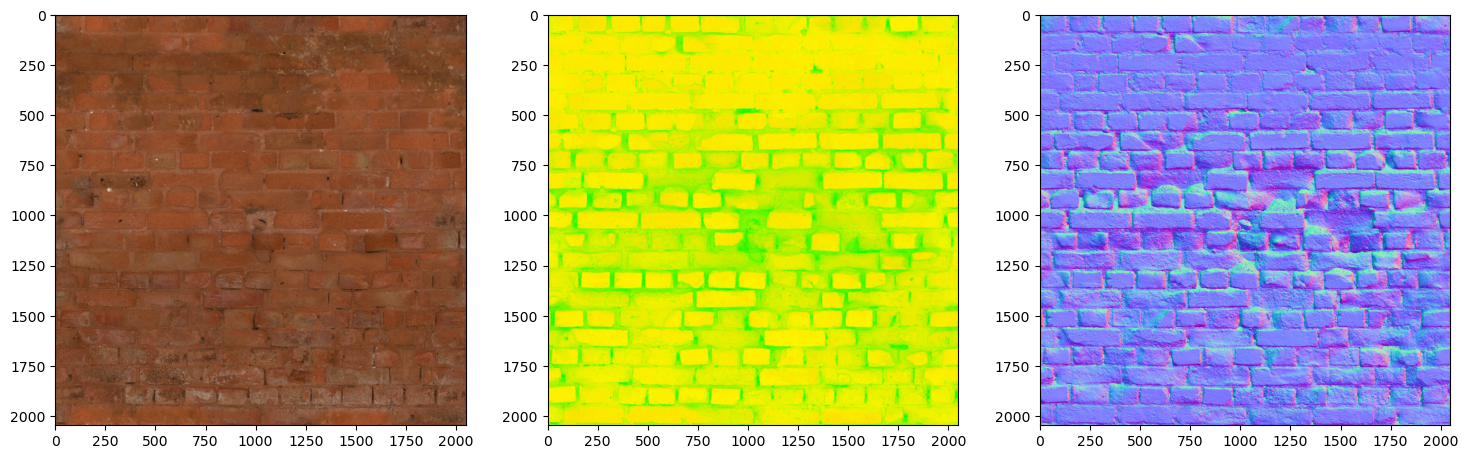

In [3]:
materials_path = "../assets/materials/"
material_name = "broken_brick_wall"
material_textures_path = materials_path + material_name + "/textures/"
ext = ".jpg"

albedo = Image.open(material_textures_path + "albedo" + ext).convert("RGB")
arm = Image.open(material_textures_path + "arm" + ext).convert("RGB")
normal = Image.open(material_textures_path + "normal" + ext).convert("RGB")

fig, axes = plt.subplots(1, 3, figsize=(18,6))
axes[0].imshow(albedo)
axes[1].imshow(arm)
axes[2].imshow(normal)

plt.show()

## Testing Data Conversion/Transform
used for converting from the PBR to a tensor and back

In [15]:
# normalizes values to [0, 1]
def gen_pbr_feature_data(albedo, arm, normal, sidelength):
    transform = Compose([
        Resize(sidelength)
    ])
        
    albedo_data = np.asarray(transform(albedo))
    arm_data = np.asarray(transform(arm))
    normal_data = np.asarray(transform(normal))

    combined = np.concatenate((albedo_data, arm_data, normal_data), axis=2)

    return combined

def extract_images(output, sidelength=None):
    if sidelength is None:
        sidelength = math.sqrt(output.shape[0])
    
    output = np.reshape(output, (sidelength, sidelength, 3 * 3))
    
    albedo_data = output[..., :3]
    arm_data = output[..., 3:6]
    normal_data = output[..., 6:]

    return albedo_data, arm_data, normal_data

(64, 64, 9)


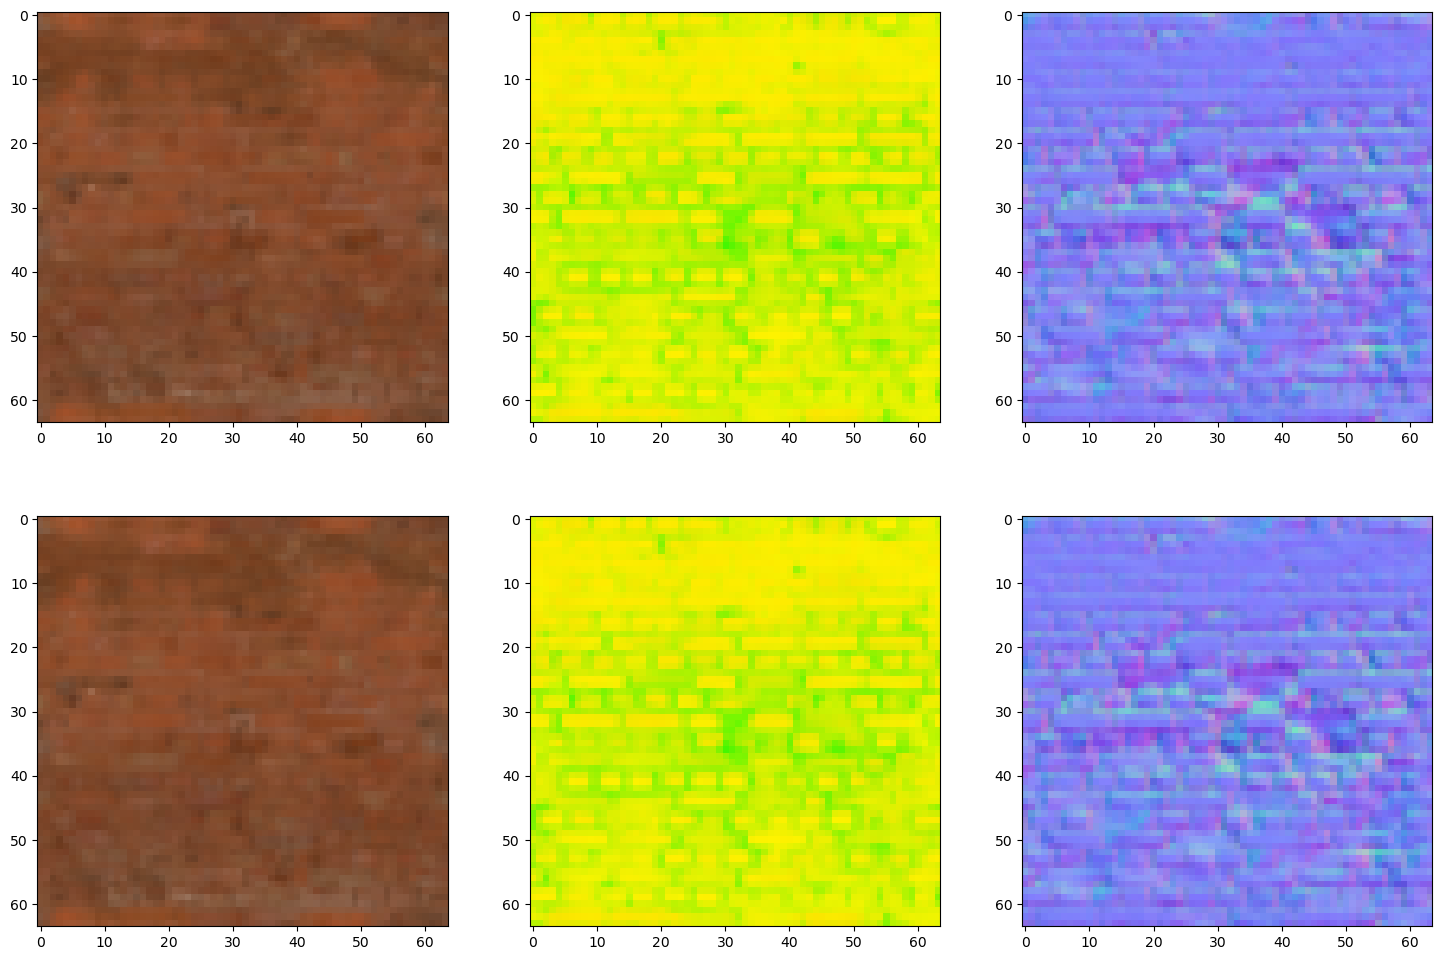

In [19]:
sidelength = 64

transform = Resize(sidelength)

mod_albedo = transform(albedo)
mod_arm = transform(arm)
mod_normal = transform(normal)

output_data = gen_pbr_feature_data(albedo, arm, normal, sidelength)


mod_output_data = np.reshape(output_data, (sidelength * sidelength, 3 * 3))

albedo_data, arm_data, normal_data = extract_images(mod_output_data / 255, sidelength)

print(output_data.shape)

fig, axes = plt.subplots(2, 3, figsize=(18,12))
axes[0, 0].imshow(mod_albedo)
axes[0, 1].imshow(mod_arm)
axes[0, 2].imshow(mod_normal)
axes[1, 0].imshow(albedo_data)
axes[1, 1].imshow(arm_data)
axes[1, 2].imshow(normal_data)

plt.show()

In [22]:
idx = 164
x_idx = idx % sidelength
y_idx = math.trunc(idx / sidelength)

print(mod_albedo.getpixel((x_idx, y_idx)), mod_arm.getpixel((x_idx, y_idx)), mod_normal.getpixel((x_idx, y_idx)))
print(output_data[y_idx][x_idx])
print(mod_output_data[idx])

(119, 74, 49) (231, 242, 0) (97, 156, 241)
[119  74  49 231 242   0  97 156 241]
[119  74  49 231 242   0  97 156 241]


## Dataset

In [4]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class PBRDataset(Dataset):
    def __init__(self, albedo_img, arm_img, normal_img, sidelength):
        super().__init__()

        self.sidelength = sidelength
        self.size = sidelength * sidelength

        transform = Resize(self.sidelength)
        
        self.albedo_img = transform(albedo_img)
        self.arm_img = transform(arm_img)
        self.normal_img = transform(normal_img)

        albedo_data = np.asarray(transform(albedo_img))
        arm_data = np.asarray(transform(arm_img))
        normal_data = np.asarray(transform(normal_img))

        combined = np.concatenate((albedo_data, arm_data, normal_data), axis=2)
        combined = np.reshape(combined, (sidelength * sidelength, 3 * 3))
        combined = combined / 255
        
        self.output_features_tensor = torch.from_numpy(combined).cuda()
        self.input_features_tensor = get_mgrid(sidelength).cuda()

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if idx > self.size or idx < 0: raise IndexError

        return self.input_features_tensor[idx], self.output_features_tensor[idx]


# Testing Dataset

C:\Users\avree\miniforge3\envs\ml\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\bld\libtorch_1753839109265\work\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([262144, 2])
torch.Size([262144, 9])


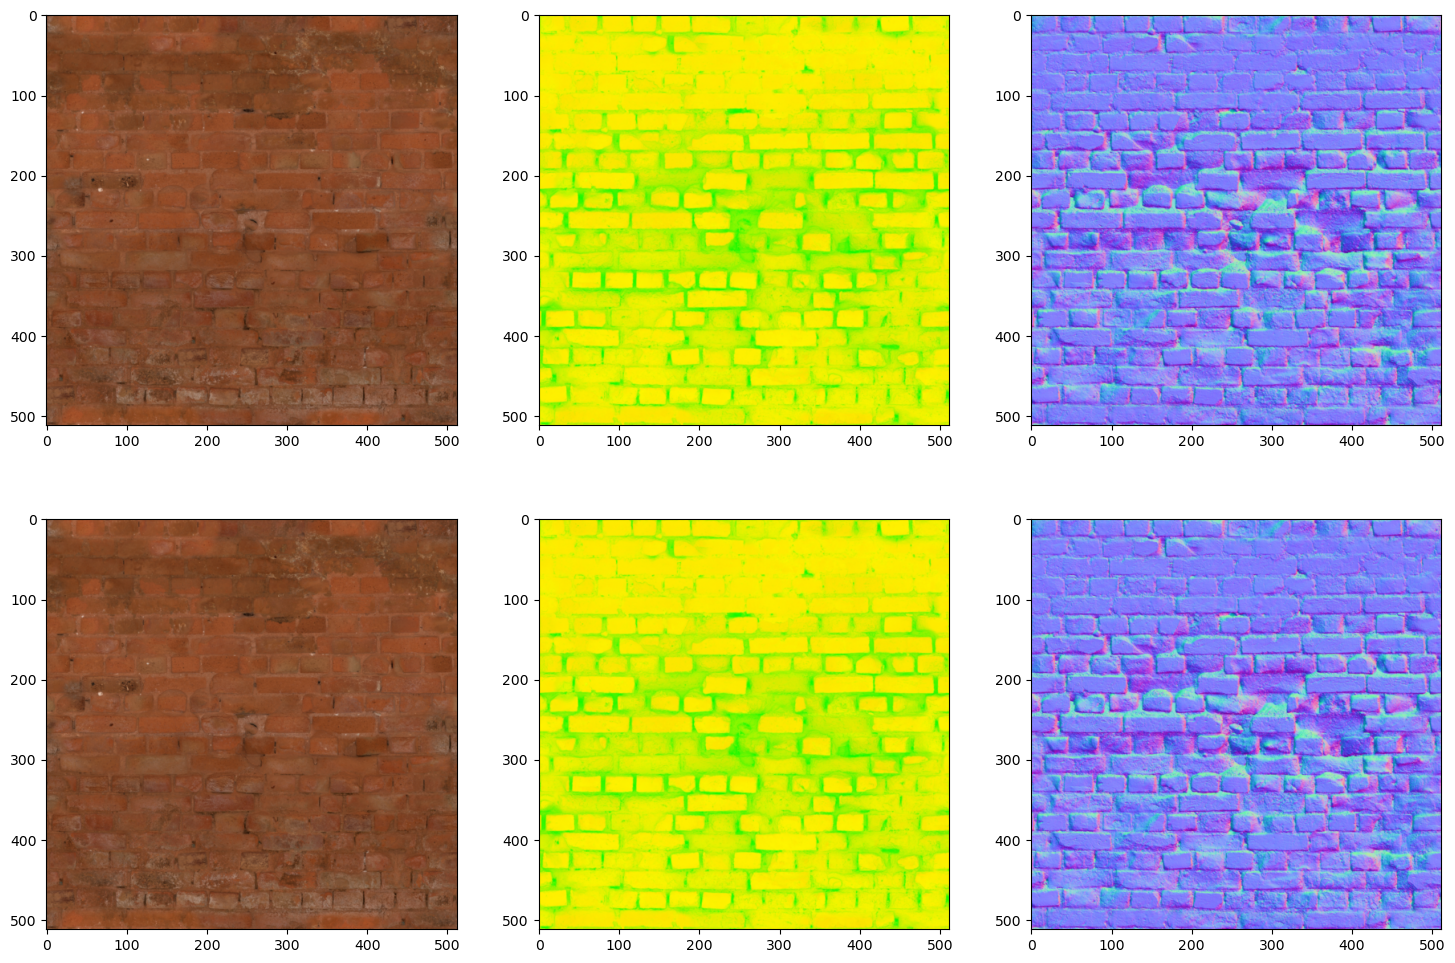

In [5]:
sidelength = 512

transform = Resize(sidelength)

mod_albedo = transform(albedo)
mod_arm = transform(arm)
mod_normal = transform(normal)

dataset = PBRDataset(albedo, arm, normal, sidelength)

output = dataset.output_features_tensor.cpu().view((sidelength, sidelength, -1))

albedo_data = output[..., :3]
arm_data = output[..., 3:6]
normal_data = output[..., 6:]

print(dataset.input_features_tensor.shape)
print(dataset.output_features_tensor.shape)

fig, axes = plt.subplots(2, 3, figsize=(18,12))
axes[0, 0].imshow(mod_albedo)
axes[0, 1].imshow(mod_arm)
axes[0, 2].imshow(mod_normal)
axes[1, 0].imshow(albedo_data)
axes[1, 1].imshow(arm_data)
axes[1, 2].imshow(normal_data)

plt.show()

# Training Loop

In [17]:
def training_loop(model, optimizer, dataloader, loss_fn, num_epochs, summary_interval):
    dataset = dataloader.dataset
    
    data_size = len(dataset)

    output_features = dataset.output_features_tensor.cpu().view((dataset.sidelength, dataset.sidelength, -1))

    albedo_data = output_features[..., :3]
    arm_data = output_features[..., 3:6]
    normal_data = output_features[..., 6:]

    
    
    for epoch_idx in range(num_epochs):

        model.eval()

        with torch.no_grad():
            test_pred = model(dataset.input_features_tensor)
            test_loss = loss_fn(test_pred, dataset.output_features_tensor)

        test_pred_features = test_pred.cpu().view((dataset.sidelength, dataset.sidelength, -1))

        albedo_pred = test_pred_features[..., :3]
        arm_pred = test_pred_features[..., 3:6]
        normal_pred = test_pred_features[..., 6:]
        
        fig, axes = plt.subplots(2, 3, figsize=(18,12))
        axes[0, 0].imshow(albedo_data)
        axes[0, 1].imshow(arm_data)
        axes[0, 2].imshow(normal_data)
        axes[1, 0].imshow(albedo_pred)
        axes[1, 1].imshow(arm_pred)
        axes[1, 2].imshow(normal_pred)

        plt.show()

        model.train()
        for batch_idx, (input_tensor, ground_truth) in enumerate(dataloader):
            pred = model(input_tensor)
            loss = loss_fn(pred, ground_truth)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % summary_interval == 0:
                print(f"loss: {loss.item():>7f} [{(batch_idx * dataloader.batch_size + len(input_tensor)):>5d}/{data_size:>5d}]")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999999].


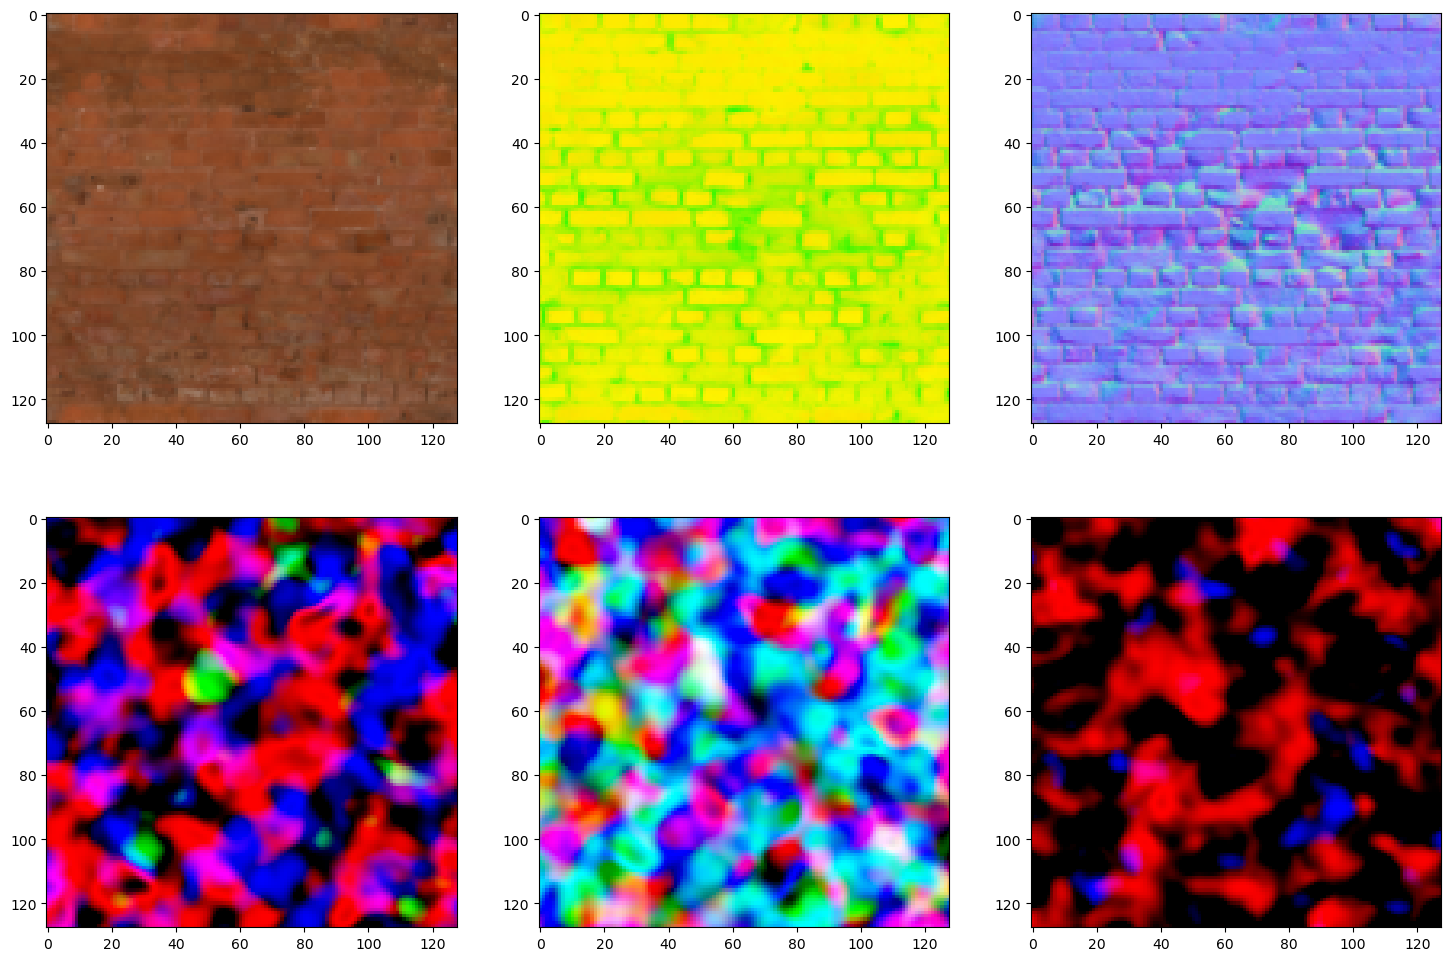

loss: 0.918735 [   64/16384]
loss: 0.243123 [  704/16384]
loss: 0.173626 [ 1344/16384]
loss: 0.149841 [ 1984/16384]
loss: 0.134150 [ 2624/16384]
loss: 0.142186 [ 3264/16384]
loss: 0.142508 [ 3904/16384]
loss: 0.126173 [ 4544/16384]
loss: 0.136493 [ 5184/16384]
loss: 0.141458 [ 5824/16384]
loss: 0.129167 [ 6464/16384]
loss: 0.173413 [ 7104/16384]
loss: 0.151167 [ 7744/16384]
loss: 0.126423 [ 8384/16384]
loss: 0.145218 [ 9024/16384]
loss: 0.134010 [ 9664/16384]
loss: 0.143192 [10304/16384]
loss: 0.140287 [10944/16384]
loss: 0.103460 [11584/16384]
loss: 0.115969 [12224/16384]
loss: 0.086656 [12864/16384]
loss: 0.089622 [13504/16384]
loss: 0.099553 [14144/16384]
loss: 0.108433 [14784/16384]
loss: 0.094486 [15424/16384]
loss: 0.075091 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49412763..0.97098446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78764224..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4470587..1.0].


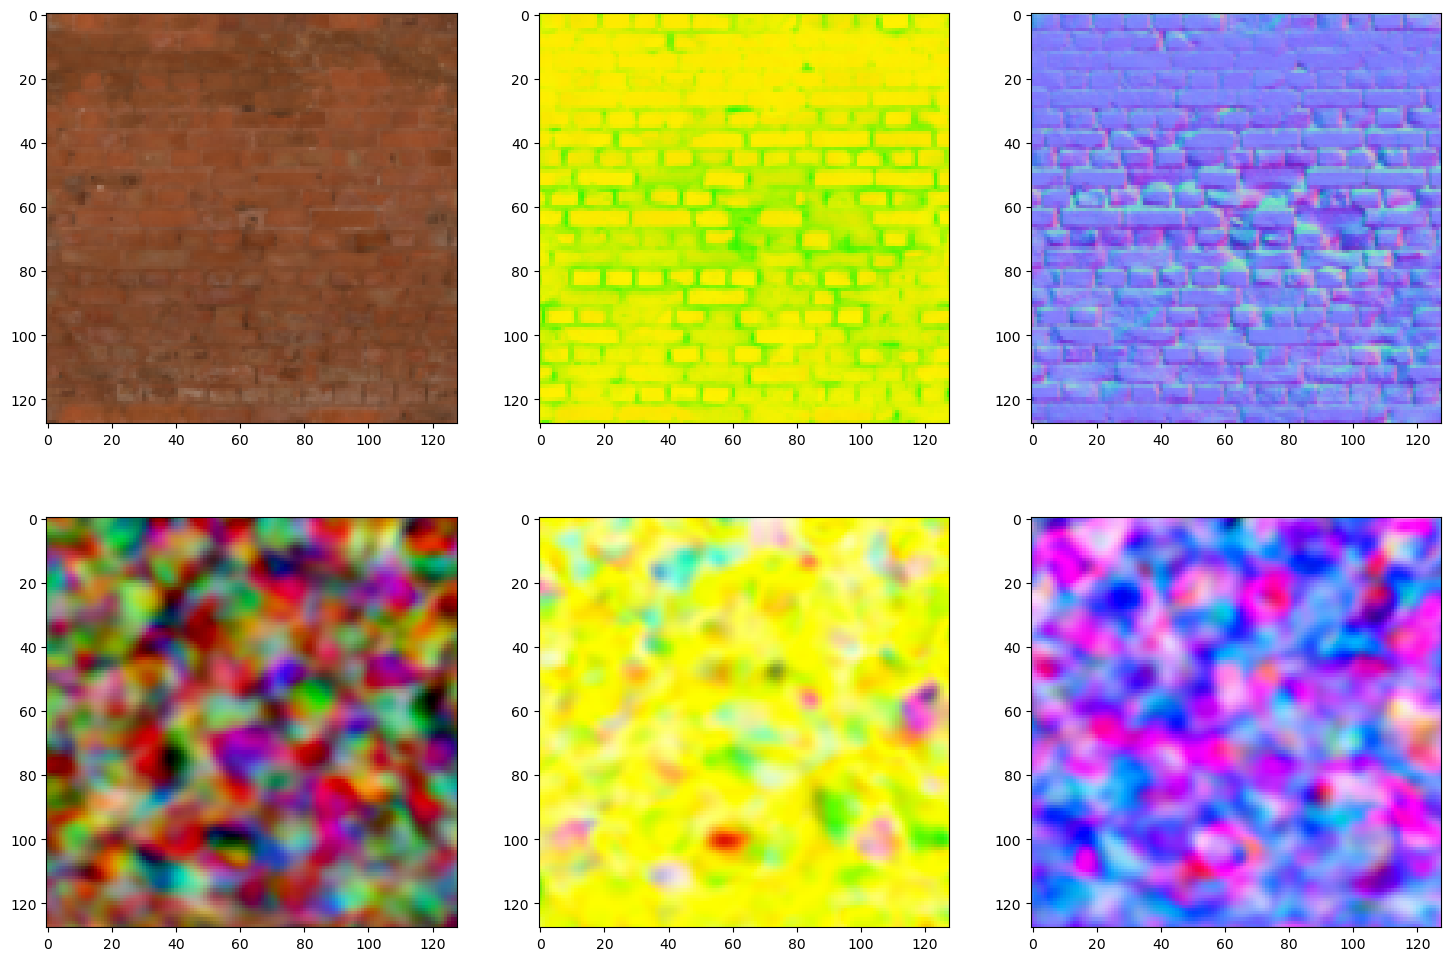

loss: 0.191813 [   64/16384]
loss: 0.112071 [  704/16384]
loss: 0.084598 [ 1344/16384]
loss: 0.070447 [ 1984/16384]
loss: 0.078956 [ 2624/16384]
loss: 0.063474 [ 3264/16384]
loss: 0.088562 [ 3904/16384]
loss: 0.066983 [ 4544/16384]
loss: 0.074593 [ 5184/16384]
loss: 0.102958 [ 5824/16384]
loss: 0.088909 [ 6464/16384]
loss: 0.131497 [ 7104/16384]
loss: 0.114293 [ 7744/16384]
loss: 0.070759 [ 8384/16384]
loss: 0.081734 [ 9024/16384]
loss: 0.099763 [ 9664/16384]
loss: 0.112182 [10304/16384]
loss: 0.096250 [10944/16384]
loss: 0.051642 [11584/16384]
loss: 0.060095 [12224/16384]
loss: 0.059671 [12864/16384]
loss: 0.073253 [13504/16384]
loss: 0.072161 [14144/16384]
loss: 0.084724 [14784/16384]
loss: 0.062872 [15424/16384]
loss: 0.060587 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031161737..0.69516915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23671229..1.0].


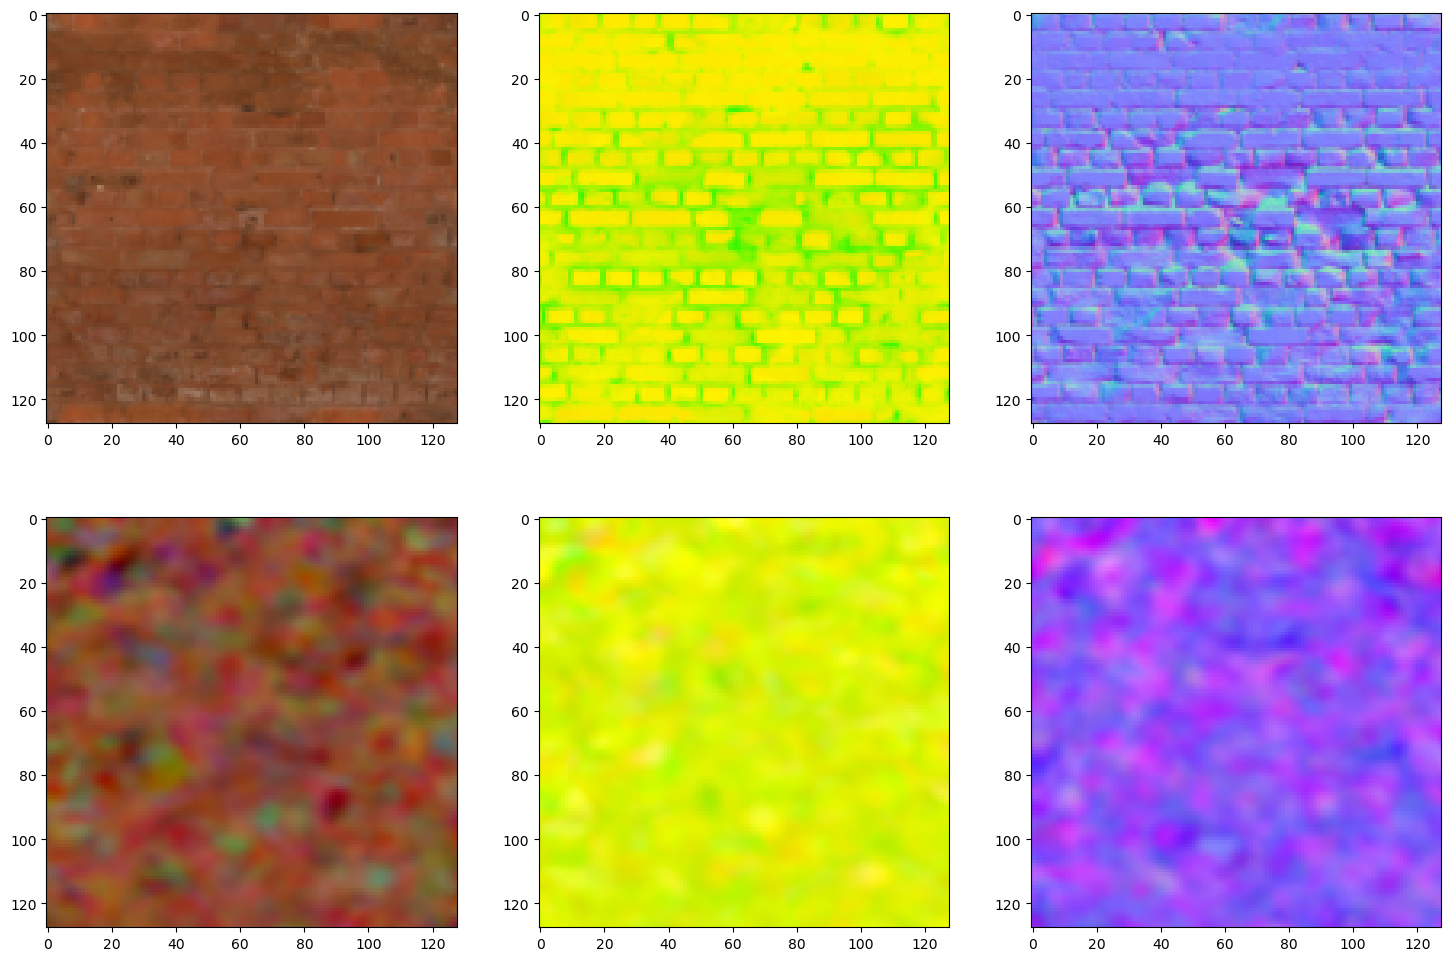

loss: 0.114030 [   64/16384]
loss: 0.065879 [  704/16384]
loss: 0.051109 [ 1344/16384]
loss: 0.041622 [ 1984/16384]
loss: 0.051488 [ 2624/16384]
loss: 0.043441 [ 3264/16384]
loss: 0.071046 [ 3904/16384]
loss: 0.042959 [ 4544/16384]
loss: 0.070927 [ 5184/16384]
loss: 0.070381 [ 5824/16384]
loss: 0.064987 [ 6464/16384]
loss: 0.098601 [ 7104/16384]
loss: 0.093984 [ 7744/16384]
loss: 0.061553 [ 8384/16384]
loss: 0.074883 [ 9024/16384]
loss: 0.069214 [ 9664/16384]
loss: 0.085027 [10304/16384]
loss: 0.087350 [10944/16384]
loss: 0.046724 [11584/16384]
loss: 0.052306 [12224/16384]
loss: 0.047236 [12864/16384]
loss: 0.058172 [13504/16384]
loss: 0.059488 [14144/16384]
loss: 0.068791 [14784/16384]
loss: 0.055477 [15424/16384]
loss: 0.049045 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011369627..0.67116106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14823428..0.9932856].


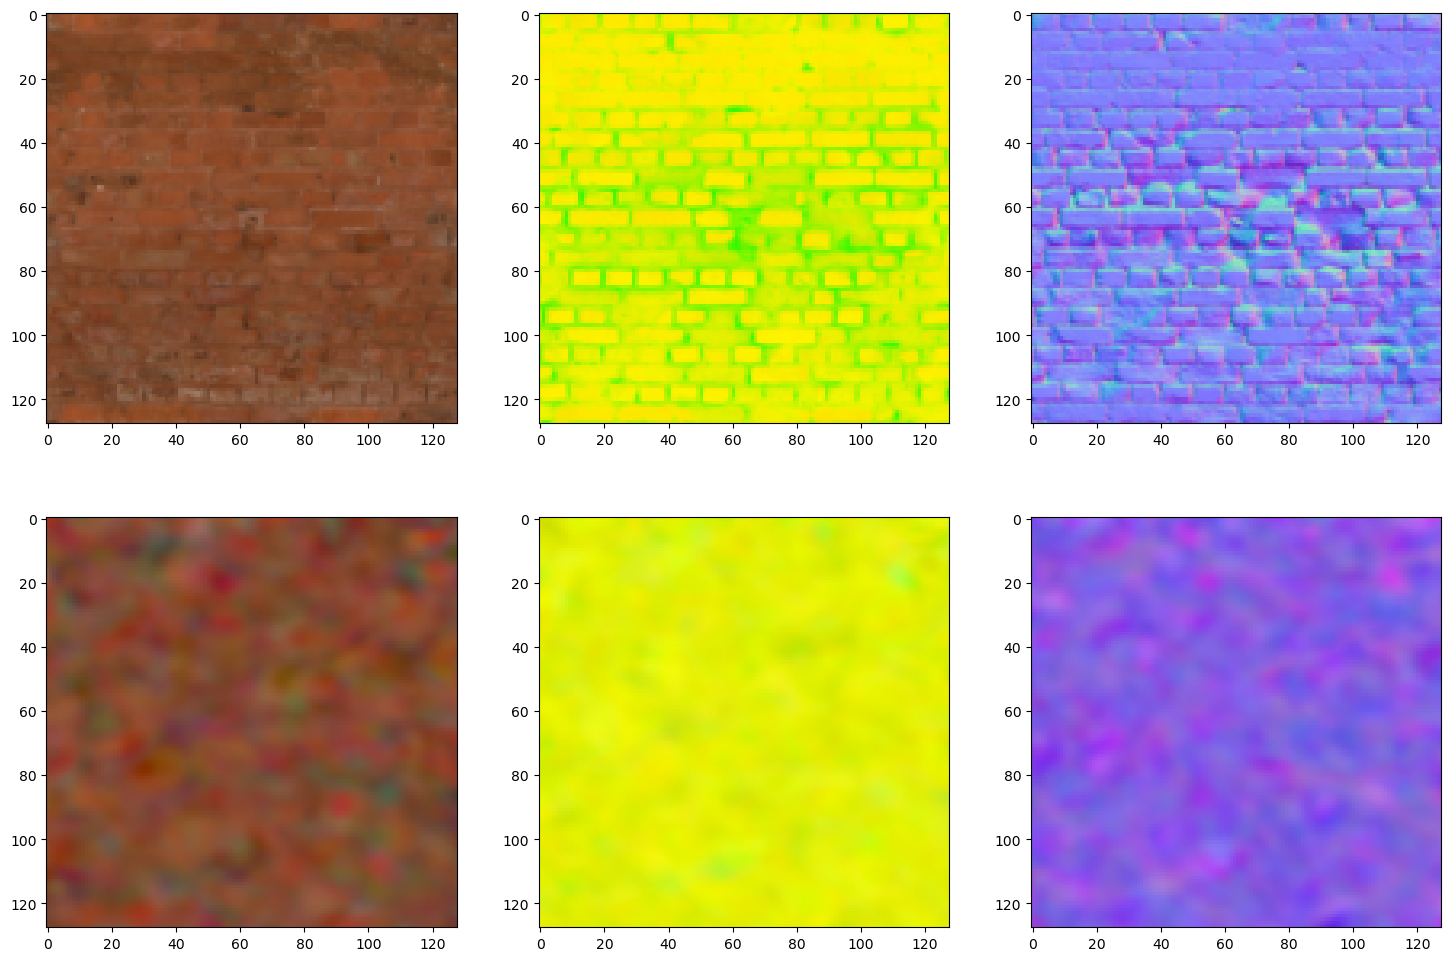

loss: 0.077908 [   64/16384]
loss: 0.056449 [  704/16384]
loss: 0.034619 [ 1344/16384]
loss: 0.018645 [ 1984/16384]
loss: 0.029239 [ 2624/16384]
loss: 0.032409 [ 3264/16384]
loss: 0.068435 [ 3904/16384]
loss: 0.040300 [ 4544/16384]
loss: 0.048999 [ 5184/16384]
loss: 0.074830 [ 5824/16384]
loss: 0.057457 [ 6464/16384]
loss: 0.104358 [ 7104/16384]
loss: 0.071492 [ 7744/16384]
loss: 0.044540 [ 8384/16384]
loss: 0.068954 [ 9024/16384]
loss: 0.066686 [ 9664/16384]
loss: 0.070673 [10304/16384]
loss: 0.083385 [10944/16384]
loss: 0.044384 [11584/16384]
loss: 0.051012 [12224/16384]
loss: 0.047071 [12864/16384]
loss: 0.055542 [13504/16384]
loss: 0.062922 [14144/16384]
loss: 0.057643 [14784/16384]
loss: 0.055685 [15424/16384]
loss: 0.044302 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10311274..0.9952985].


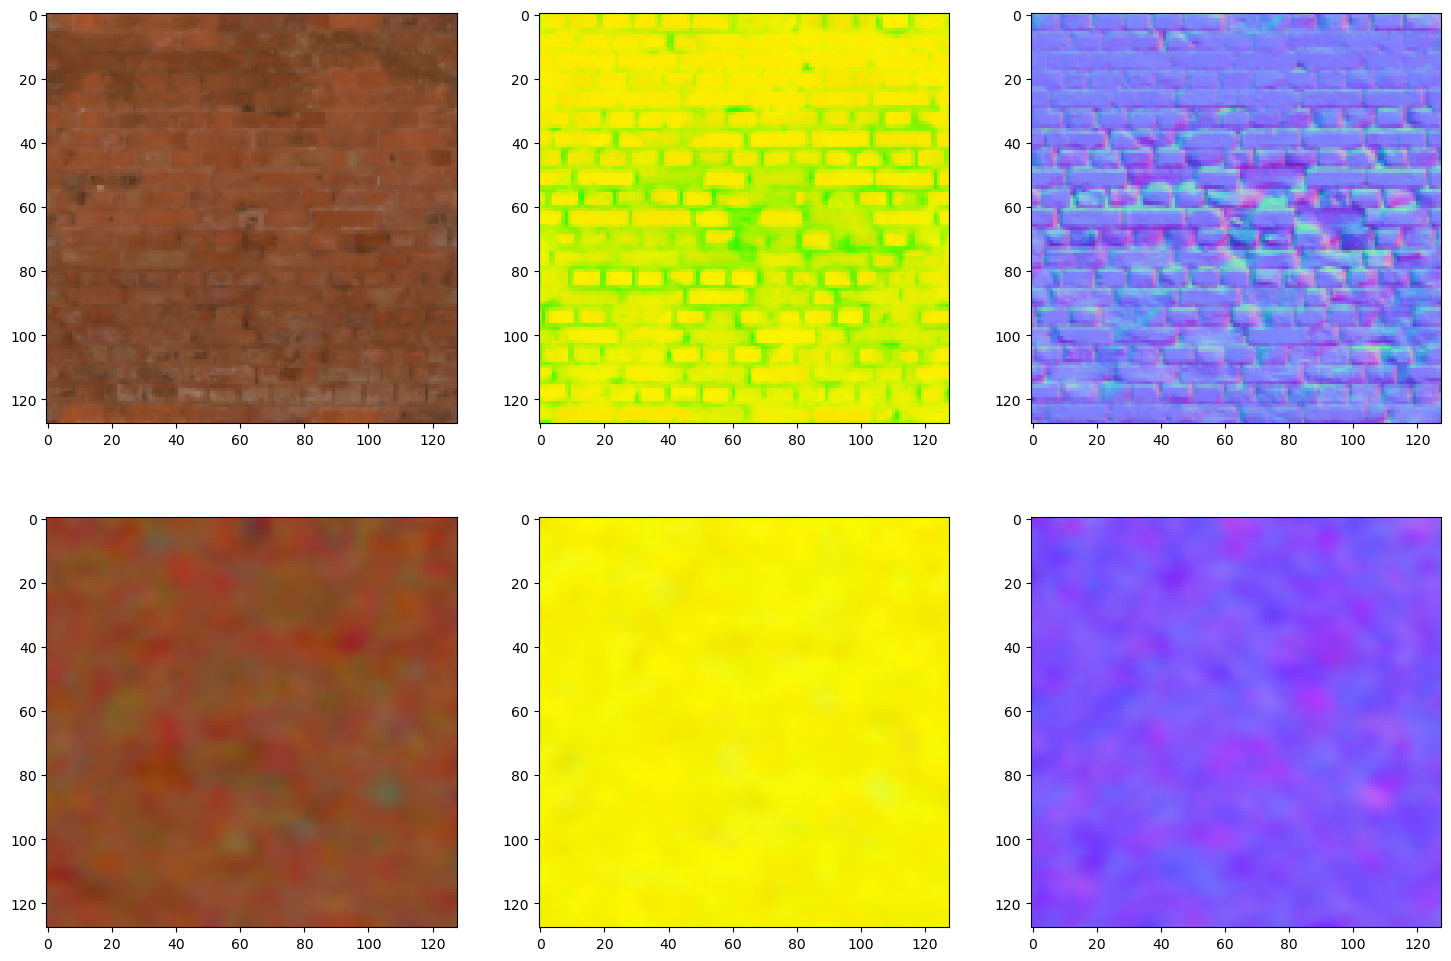

loss: 0.090617 [   64/16384]
loss: 0.044017 [  704/16384]
loss: 0.038816 [ 1344/16384]
loss: 0.035514 [ 1984/16384]
loss: 0.048145 [ 2624/16384]
loss: 0.034348 [ 3264/16384]
loss: 0.073778 [ 3904/16384]
loss: 0.035669 [ 4544/16384]
loss: 0.041813 [ 5184/16384]
loss: 0.068332 [ 5824/16384]
loss: 0.065395 [ 6464/16384]
loss: 0.115035 [ 7104/16384]
loss: 0.059446 [ 7744/16384]
loss: 0.049558 [ 8384/16384]
loss: 0.088059 [ 9024/16384]
loss: 0.068845 [ 9664/16384]
loss: 0.074330 [10304/16384]
loss: 0.077896 [10944/16384]
loss: 0.044512 [11584/16384]
loss: 0.054969 [12224/16384]
loss: 0.039652 [12864/16384]
loss: 0.059307 [13504/16384]
loss: 0.061393 [14144/16384]
loss: 0.058516 [14784/16384]
loss: 0.051121 [15424/16384]
loss: 0.043653 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09349003..0.9902048].


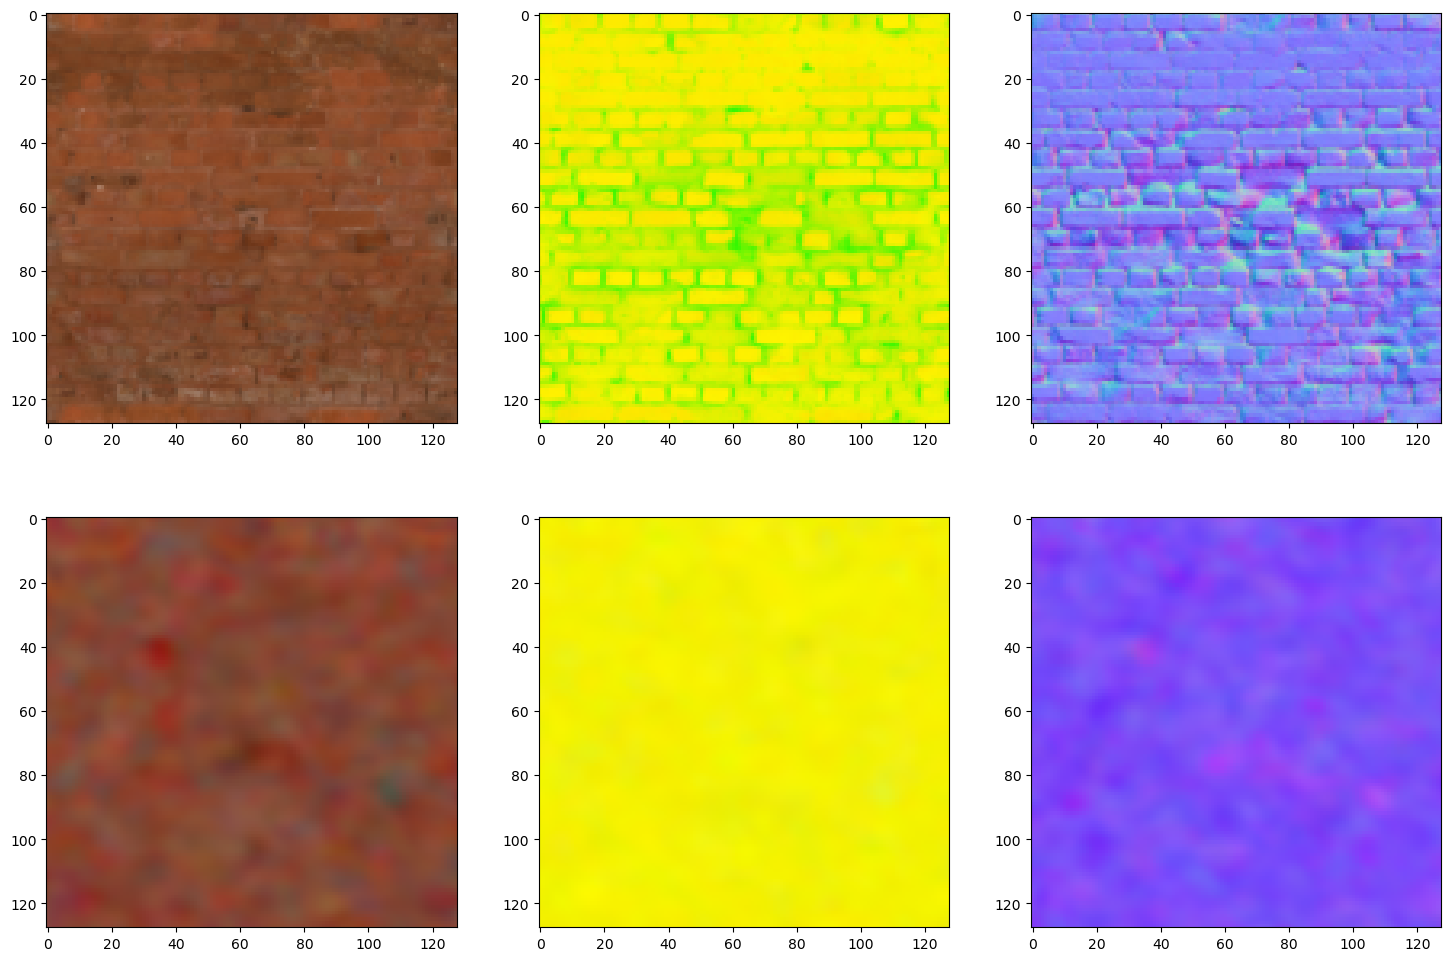

loss: 0.078377 [   64/16384]
loss: 0.046789 [  704/16384]
loss: 0.036647 [ 1344/16384]
loss: 0.023389 [ 1984/16384]
loss: 0.035514 [ 2624/16384]
loss: 0.033088 [ 3264/16384]
loss: 0.078549 [ 3904/16384]
loss: 0.039271 [ 4544/16384]
loss: 0.046948 [ 5184/16384]
loss: 0.060273 [ 5824/16384]
loss: 0.065252 [ 6464/16384]
loss: 0.112193 [ 7104/16384]
loss: 0.053855 [ 7744/16384]
loss: 0.039168 [ 8384/16384]
loss: 0.066829 [ 9024/16384]
loss: 0.064335 [ 9664/16384]
loss: 0.069582 [10304/16384]
loss: 0.089675 [10944/16384]
loss: 0.046161 [11584/16384]
loss: 0.054989 [12224/16384]
loss: 0.042388 [12864/16384]
loss: 0.059379 [13504/16384]
loss: 0.061943 [14144/16384]
loss: 0.062496 [14784/16384]
loss: 0.059265 [15424/16384]
loss: 0.042831 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.103999116..0.9877309].


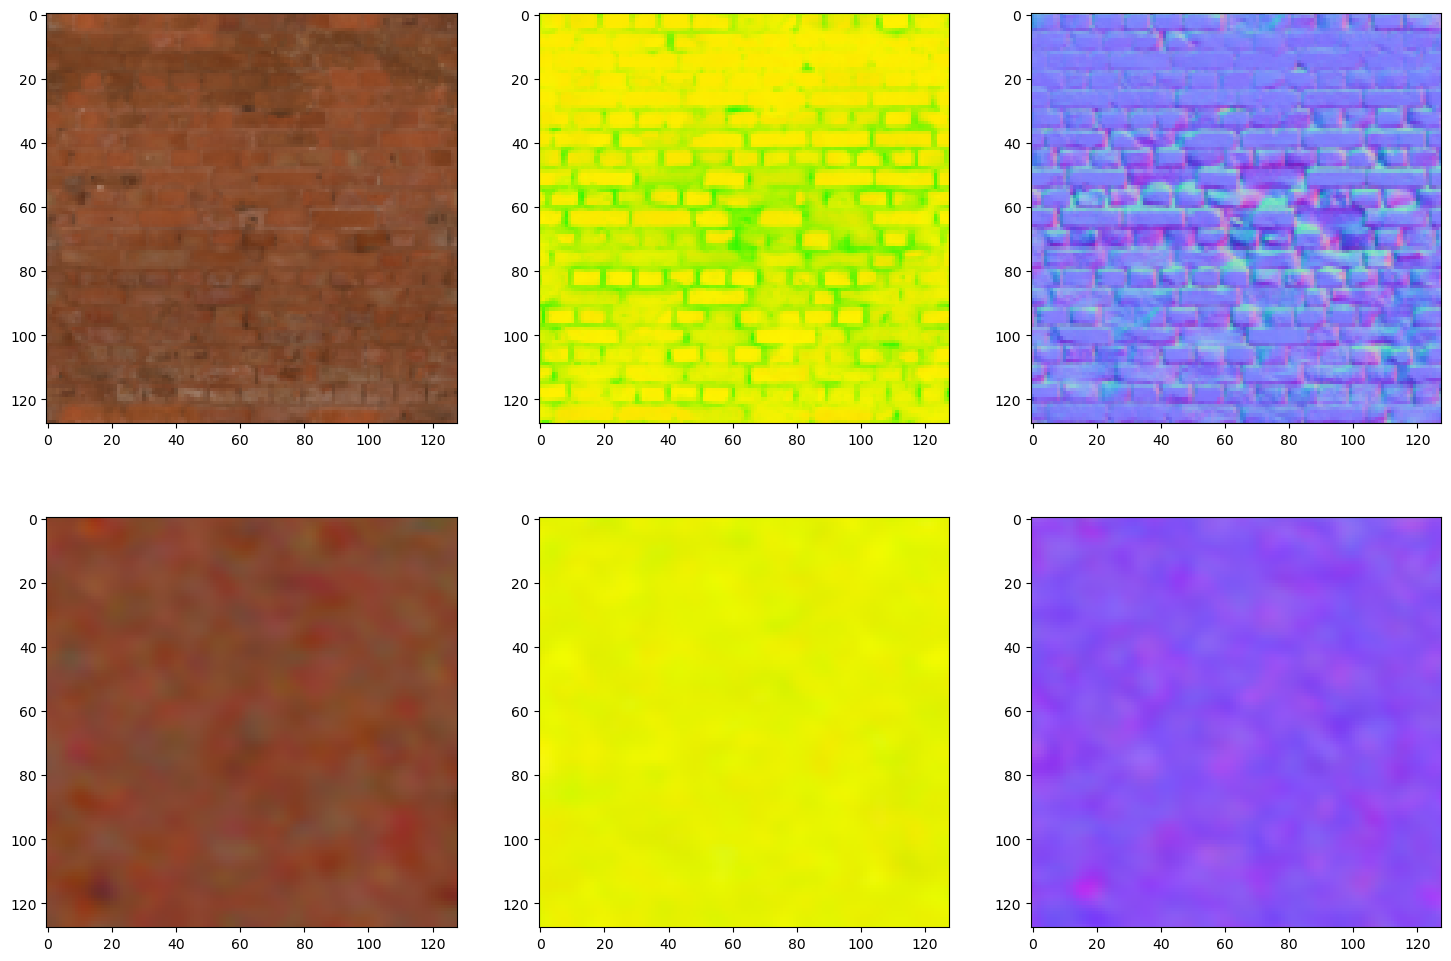

loss: 0.078597 [   64/16384]
loss: 0.055482 [  704/16384]
loss: 0.029396 [ 1344/16384]
loss: 0.023611 [ 1984/16384]
loss: 0.045393 [ 2624/16384]
loss: 0.025001 [ 3264/16384]
loss: 0.069384 [ 3904/16384]
loss: 0.036246 [ 4544/16384]
loss: 0.056895 [ 5184/16384]
loss: 0.060445 [ 5824/16384]
loss: 0.054186 [ 6464/16384]
loss: 0.107330 [ 7104/16384]
loss: 0.057755 [ 7744/16384]
loss: 0.034229 [ 8384/16384]
loss: 0.061758 [ 9024/16384]
loss: 0.049933 [ 9664/16384]
loss: 0.074287 [10304/16384]
loss: 0.083428 [10944/16384]
loss: 0.048533 [11584/16384]
loss: 0.051825 [12224/16384]
loss: 0.036877 [12864/16384]
loss: 0.055051 [13504/16384]
loss: 0.055412 [14144/16384]
loss: 0.052875 [14784/16384]
loss: 0.053442 [15424/16384]
loss: 0.042103 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059644178..0.99419016].


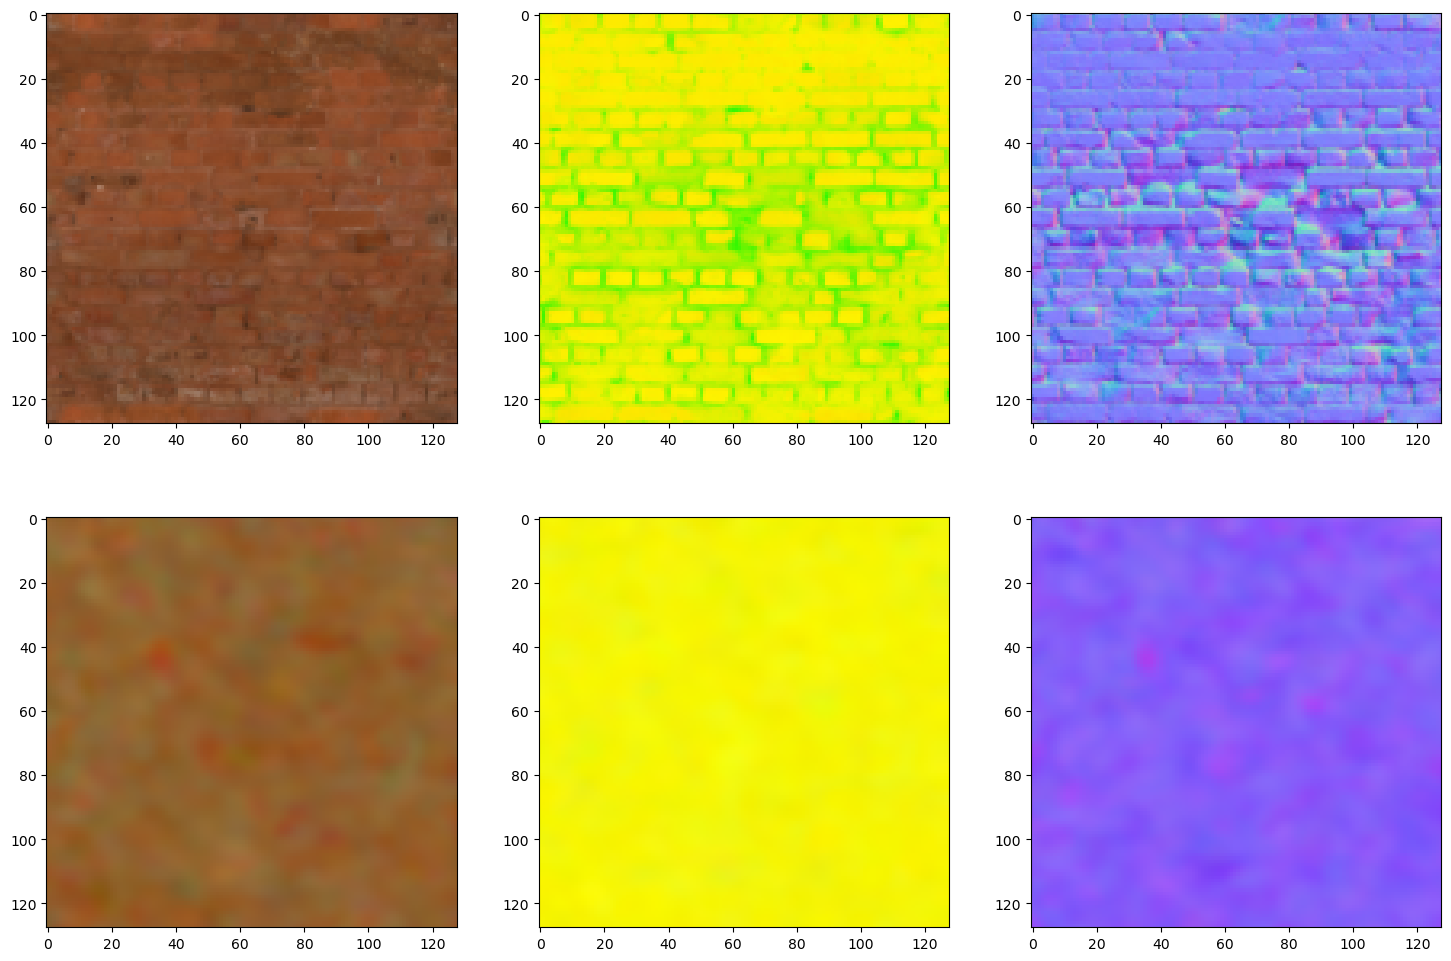

loss: 0.079976 [   64/16384]
loss: 0.057329 [  704/16384]
loss: 0.028166 [ 1344/16384]
loss: 0.017663 [ 1984/16384]
loss: 0.035957 [ 2624/16384]
loss: 0.027049 [ 3264/16384]
loss: 0.065895 [ 3904/16384]
loss: 0.034537 [ 4544/16384]
loss: 0.046605 [ 5184/16384]
loss: 0.051122 [ 5824/16384]
loss: 0.074666 [ 6464/16384]
loss: 0.115393 [ 7104/16384]
loss: 0.081387 [ 7744/16384]
loss: 0.042990 [ 8384/16384]
loss: 0.059582 [ 9024/16384]
loss: 0.059161 [ 9664/16384]
loss: 0.076226 [10304/16384]
loss: 0.085802 [10944/16384]
loss: 0.043138 [11584/16384]
loss: 0.045340 [12224/16384]
loss: 0.040099 [12864/16384]
loss: 0.059336 [13504/16384]
loss: 0.067875 [14144/16384]
loss: 0.057947 [14784/16384]
loss: 0.050422 [15424/16384]
loss: 0.042824 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0430969..0.98605955].


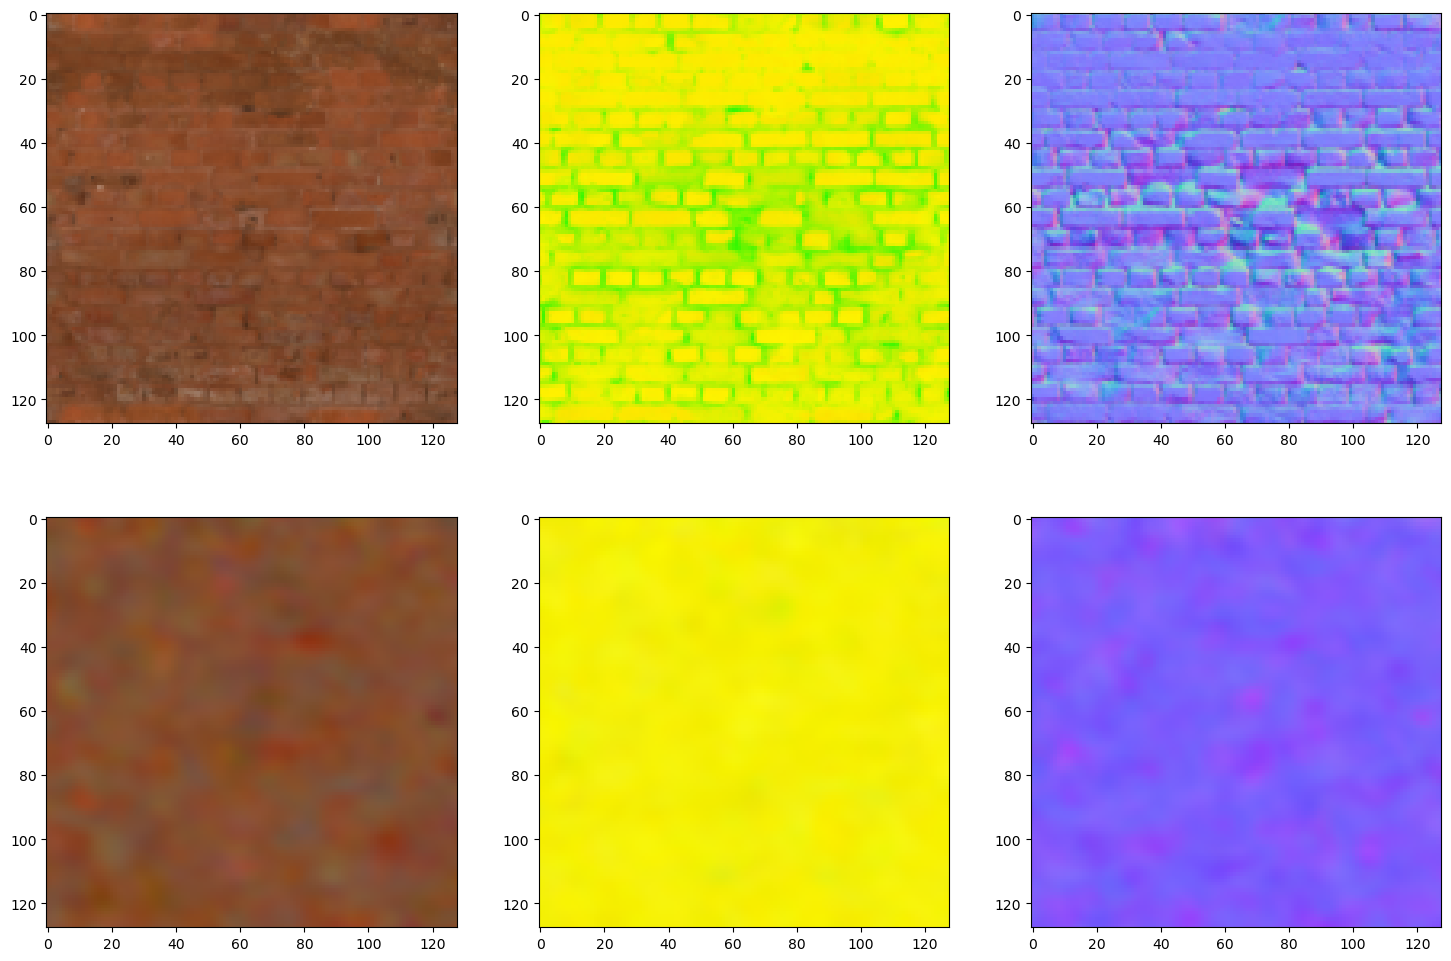

loss: 0.080841 [   64/16384]
loss: 0.043662 [  704/16384]
loss: 0.032916 [ 1344/16384]
loss: 0.020963 [ 1984/16384]
loss: 0.035680 [ 2624/16384]
loss: 0.033090 [ 3264/16384]
loss: 0.070231 [ 3904/16384]
loss: 0.035651 [ 4544/16384]
loss: 0.038016 [ 5184/16384]
loss: 0.055022 [ 5824/16384]
loss: 0.062254 [ 6464/16384]
loss: 0.111415 [ 7104/16384]
loss: 0.065556 [ 7744/16384]
loss: 0.043753 [ 8384/16384]
loss: 0.060024 [ 9024/16384]
loss: 0.053533 [ 9664/16384]
loss: 0.068748 [10304/16384]
loss: 0.084736 [10944/16384]
loss: 0.042878 [11584/16384]
loss: 0.051645 [12224/16384]
loss: 0.042903 [12864/16384]
loss: 0.045100 [13504/16384]
loss: 0.057083 [14144/16384]
loss: 0.059726 [14784/16384]
loss: 0.054297 [15424/16384]
loss: 0.033504 [16064/16384]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04965252..0.988166].


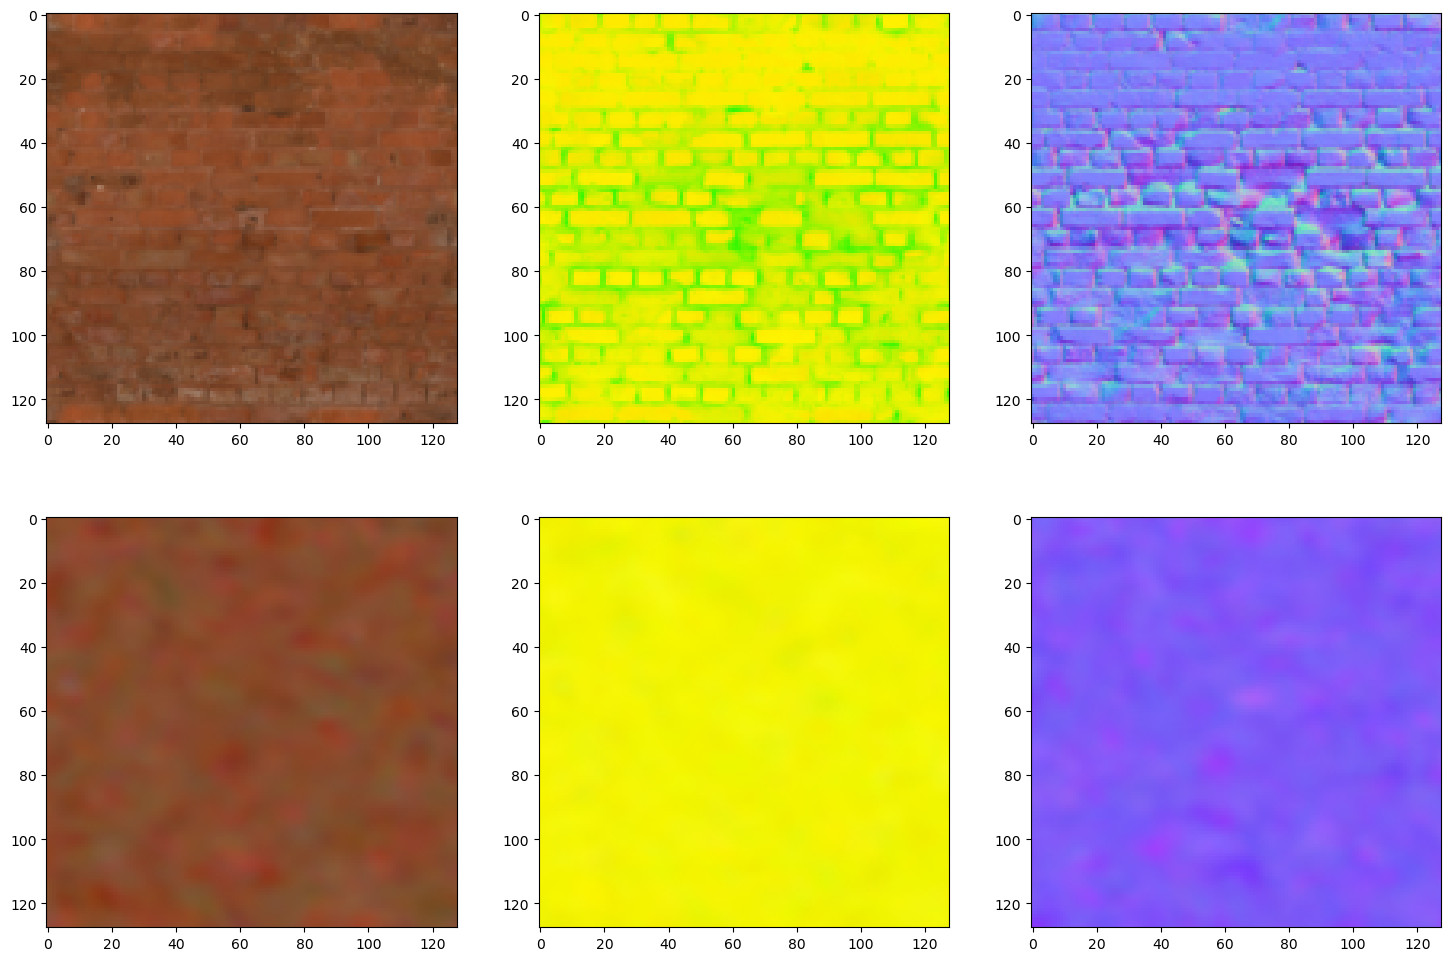

loss: 0.080442 [   64/16384]
loss: 0.045080 [  704/16384]
loss: 0.028949 [ 1344/16384]
loss: 0.024124 [ 1984/16384]
loss: 0.036025 [ 2624/16384]
loss: 0.024400 [ 3264/16384]
loss: 0.071522 [ 3904/16384]
loss: 0.041072 [ 4544/16384]
loss: 0.044076 [ 5184/16384]
loss: 0.061192 [ 5824/16384]
loss: 0.074868 [ 6464/16384]
loss: 0.097045 [ 7104/16384]
loss: 0.082121 [ 7744/16384]
loss: 0.042016 [ 8384/16384]
loss: 0.076476 [ 9024/16384]
loss: 0.051086 [ 9664/16384]
loss: 0.064096 [10304/16384]
loss: 0.086324 [10944/16384]
loss: 0.040296 [11584/16384]
loss: 0.047810 [12224/16384]
loss: 0.038686 [12864/16384]
loss: 0.054744 [13504/16384]
loss: 0.060931 [14144/16384]
loss: 0.059597 [14784/16384]
loss: 0.056003 [15424/16384]
loss: 0.031135 [16064/16384]


In [20]:
model = models.Siren(in_features=2, out_features=3*3, hidden_features=64, hidden_layers=3).cuda()

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

dataset = PBRDataset(albedo, arm, normal, sidelength=128)
dataloader = DataLoader(dataset, batch_size=64)

loss_fn = torch.nn.L1Loss()

num_epochs = 10

training_loop(model, optimizer, dataloader, loss_fn, num_epochs, 10)